# Case Study 2 - Multiple Runs

This notebook uses the ```seaborn```, which is not listed as a requirement for this library. Therefore, make sure to install it before running this notebook. To install it, use the following:

```console
> pip install seaborn
```

This notebook, as in **case2.ipynb**, we will explore the **wilt** dataset. Similar to **case1.ipynb/case1_stat.ipynb**, we will run the same experiment multiple times in order to see if a preprocessing step improves the model's performance with statistical significance.

## 0 - Defining Basic Functionalities

In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
from matplotlib.pyplot import figure

import raimitigations.dataprocessing as dp
import case_study_utils as cs

N_EXEC = 50

USE_AUC_TH = False

In [2]:
def test_base(df, label_col, n_exec, model_name):
	result_list = []
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr(df, label_col, n_exec, model_name):
	result_list = []
	proc_df = cs.remove_corr_feat(df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat


# -----------------------------------
def test_corr_transf(df, label_col, n_exec, scaler_ref, model_name, num_col=None):
	result_list = []
	proc_df = cs.remove_corr_feat(df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat

# -----------------------------------
def test_smote_transf(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, under=False):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = cs.remove_corr_feat(proc_df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = cs.artificial_smote(train_x, train_y, art_str, under)
		if feat_sel_type is not None:
			train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat



# -----------------------------------
def test_ctgan_first(df, label_col, n_exec, model_name, rcorr=True, scaler_ref=None, num_col=None, feat_sel_type=None, art_str=None, savefile=None):
	result_list = []
	proc_df = df
	if rcorr:
		proc_df = cs.remove_corr_feat(proc_df, label_col)
	for n in range(n_exec):
		train_x, test_x, train_y, test_y = dp.split_data(proc_df, label_col, test_size=0.25)
		if art_str is not None:
			train_x, train_y = cs.artificial_ctgan(train_x, train_y, art_str, savefile, epochs=1000)
		if feat_sel_type is not None:
			train_x, test_x = cs.feature_selection(train_x, train_y, test_x, feat_sel_type)
		if scaler_ref is not None:
			train_x, test_x = cs.transform_num_data(train_x, test_x, scaler_ref, num_col)
		result = dp.train_model_fetch_results(train_x, train_y, test_x, test_y, model_name, USE_AUC_TH)
		result_list.append(result)

	result_stat = cs.result_statistics(result_list)

	return result_stat

## 1 - Understanding the Data

In [3]:
df = database.load_wilt()
label_col = "class"
df[label_col] = df[label_col].replace({"w": 1, "n": 0})
df

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,1,120.362774,205.500000,119.395349,416.581395,20.676318
1,1,124.739583,202.800000,115.333333,354.333333,16.707151
2,1,134.691964,199.285714,116.857143,477.857143,22.496712
3,1,127.946309,178.368421,92.368421,278.473684,14.977453
4,1,135.431548,197.000000,112.690476,532.952381,17.604193
...,...,...,...,...,...,...
495,0,123.554348,202.826087,106.391304,364.565217,17.314068
496,0,121.549028,276.220000,175.593333,402.620000,13.394574
497,0,119.076687,247.951220,113.365854,808.024390,24.830059
498,0,107.944444,197.000000,90.000000,451.000000,8.214887


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4839 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   class       4839 non-null   int64  
 1   GLCM_pan    4839 non-null   float64
 2   Mean_Green  4839 non-null   float64
 3   Mean_Red    4839 non-null   float64
 4   Mean_NIR    4839 non-null   float64
 5   SD_pan      4839 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 264.6 KB


In [5]:
num_col = ["GLCM_pan", "Mean_Green", "Mean_Red", "Mean_NIR", "SD_pan"]

## 2 - Efficiency of Different Classes from raimitigations.dataprocessing lib

### KNN Model

#### Data Transformations

Here we compare 8 different training pipelines with a KNN model. For each pipeline, 50 runs are performed, and the mean and stdev of the metrics are computed and plotted in the graph below.

- baseline dataset
- baseline dataset, removal of correlated features
- baseline dataset, removal of correlated features, standard scaler
- baseline dataset, removal of correlated features, minmax scaler
- baseline dataset, removal of correlated features, quantile transformer
- baseline dataset, removal of correlated features, data normalizer
- baseline dataset, removal of correlated features, robust scaler
- baseline dataset, removal of correlated features, power transformer

Note: Some of the experiments below take 10+ min to run. You may change ``N_EXEC`` to a smaller number to decrease the time it takes to run the notebook.

In [6]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Power")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


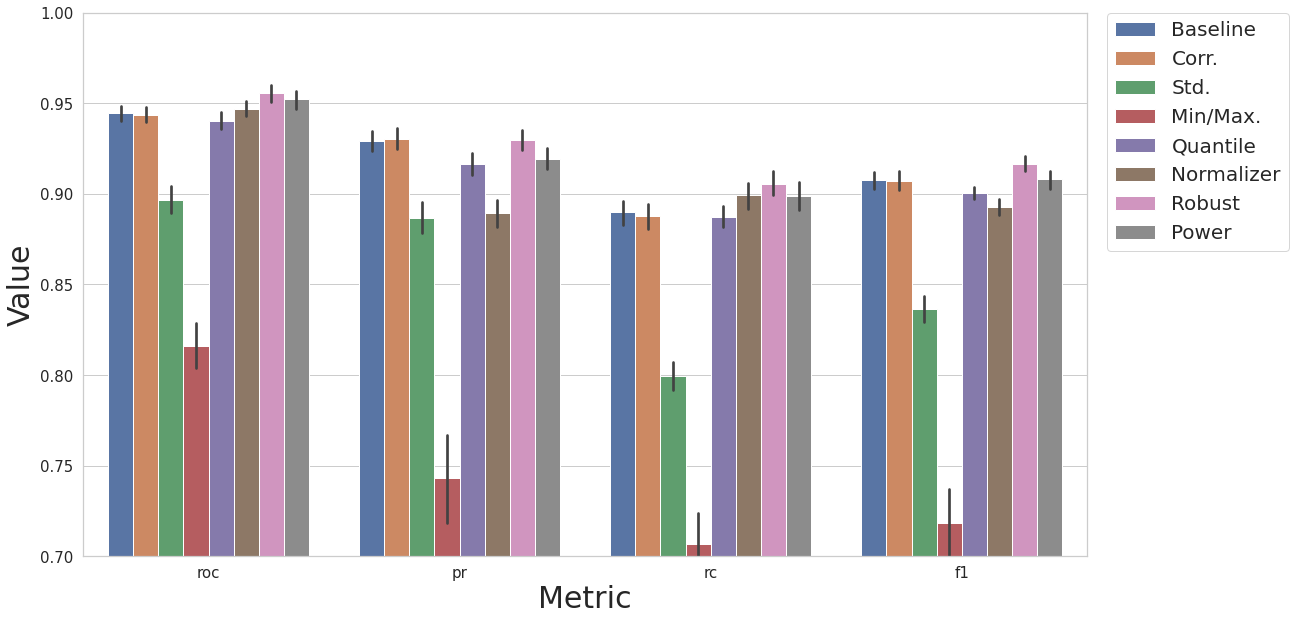

In [8]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

#### Feature Selection

Now we will perform feature selection, where all features are removed from the dataset to improve the model performance. We will compare two different feature selection pipelines with two baseline models.

- Baseline KNN model
- KNN model with robust scaler
- KNN model, robust scaler, sequential feature selection
- KNN model, robust scaler, CatBoost feature selection

In [9]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type="backward")
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.Robust")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=False, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost Robust")

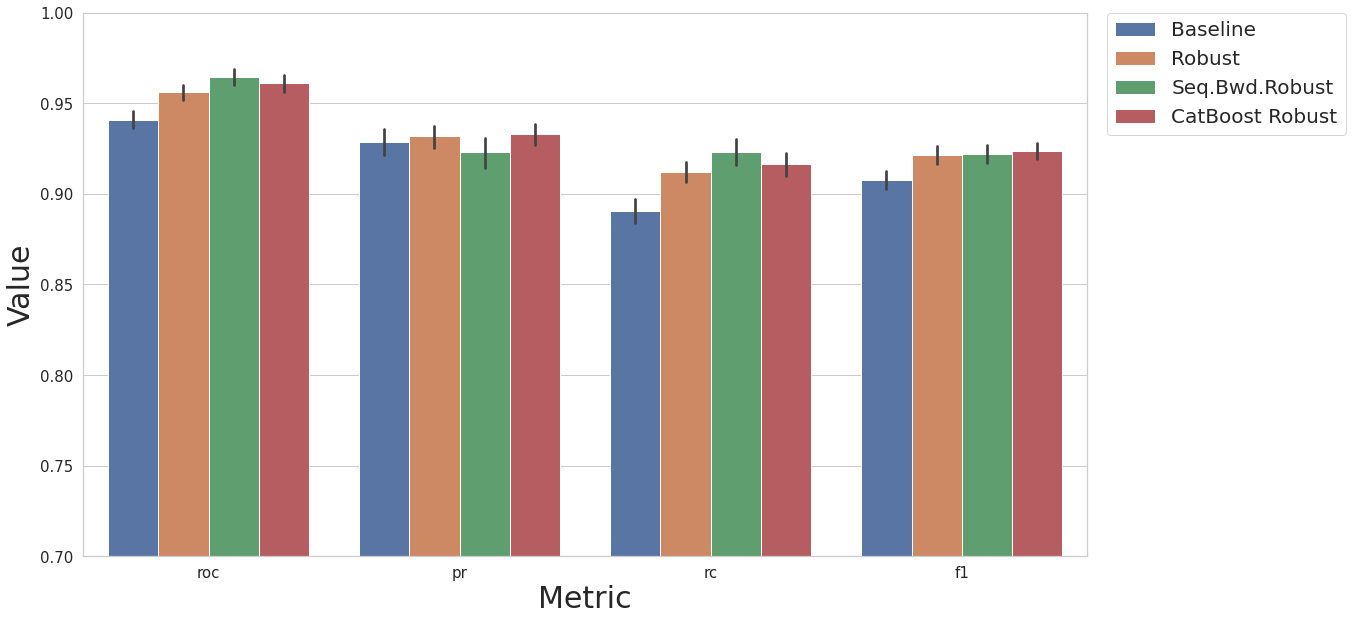

In [10]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

#### Artificial Instances - SMOTE

Since we have imbalanced classes (most trees are not diseased), we will experiment with creating artificial data.

- baseline KNN model
- baseline KNN model with robust scaler and removal of correlated features
- KNN model, remove correlated features, SMOTE artificial data
- KNN model, remove correlated features, robust scaler, SMOTE artificial data
- KNN model, remove correlated features, SMOTE artificial data, TomekLink under sampling
- KNN model, remove correlated features, robust scaler, SMOTE artificial data, TomekLink under sampling

In [11]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.2, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM Robust")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.2, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.2, under=True)
result_df = cs.add_results_df(result_df, restult_fs, "SM+TK Robust")

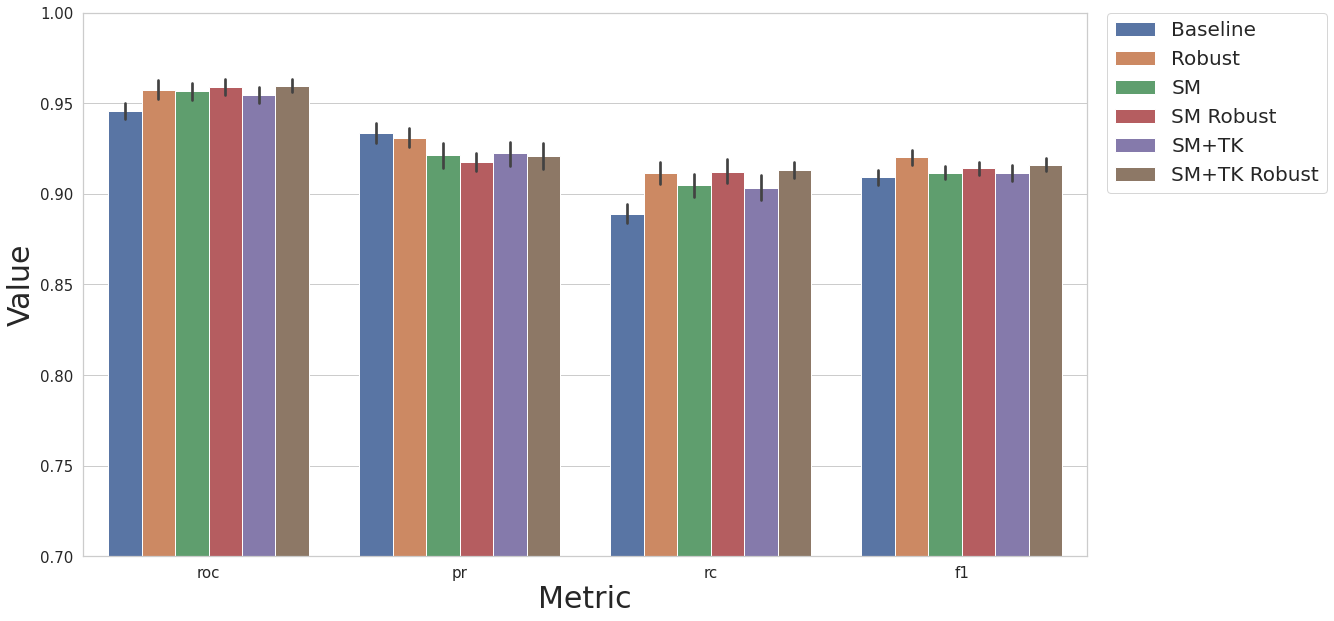

In [12]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

Now we will compare different quantities of artificial instances generated (the float refers to the ratio of minority class to majority class). All of these models contain correlated feature removal and the robust scaler.

In [13]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.1, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM Robust 0.1")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.4, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM Robust 0.4")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.6, under=False)
result_df = cs.add_results_df(result_df, restult_fs, "SM Robust 0.6")


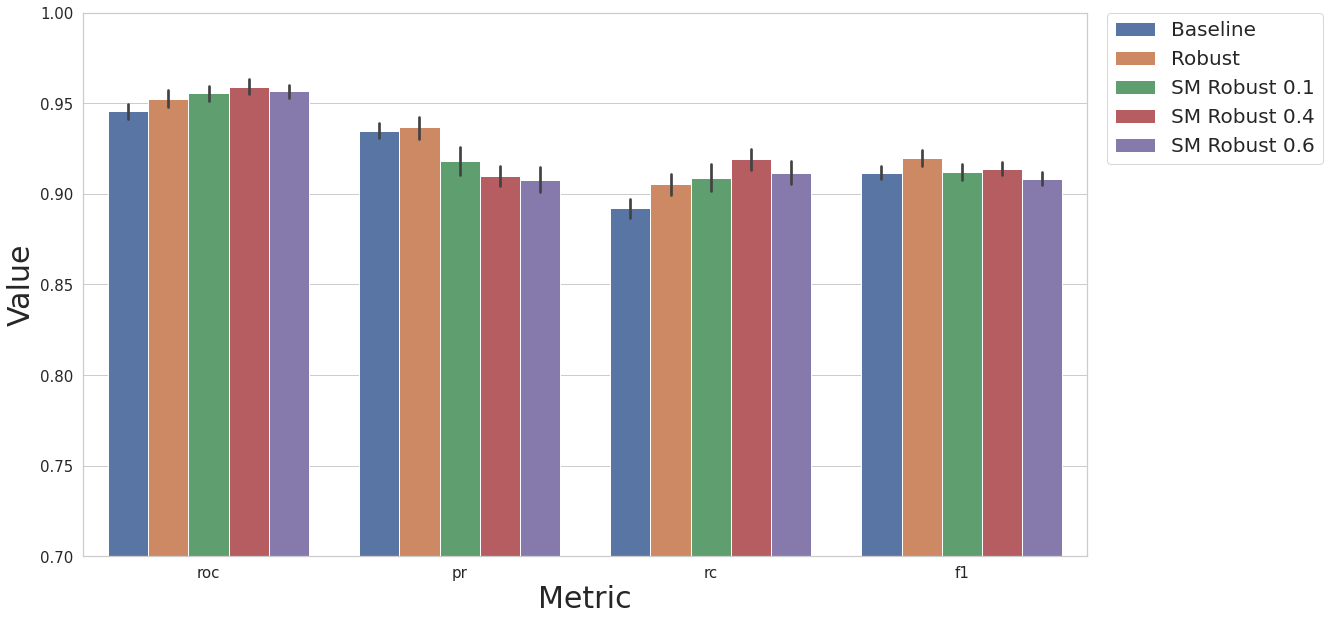

In [14]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

#### Artificial Instances - CTGAN

Instead of doing over sampling using SMOTE and its variations, we can create artificial instances of the minority class using the CTGAN. Here we perform the following experiments:

- KNN baseline model
- baseline KNN model with robust scaler and removal of correlated features
- KNN model, robust scaler, removal of correlated features, over sampling with CTGAN ratio of 0.15
- KNN model, robust scaler, removal of correlated features, over sampling with CTGAN ratio of 0.3

In [15]:
MODEL_NAME = "knn"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.15, savefile="2_1.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.15 Robust")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=dp.DataRobustScaler, num_col=num_col, feat_sel_type=None, art_str=0.3, savefile="2_2.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.3 Robust")


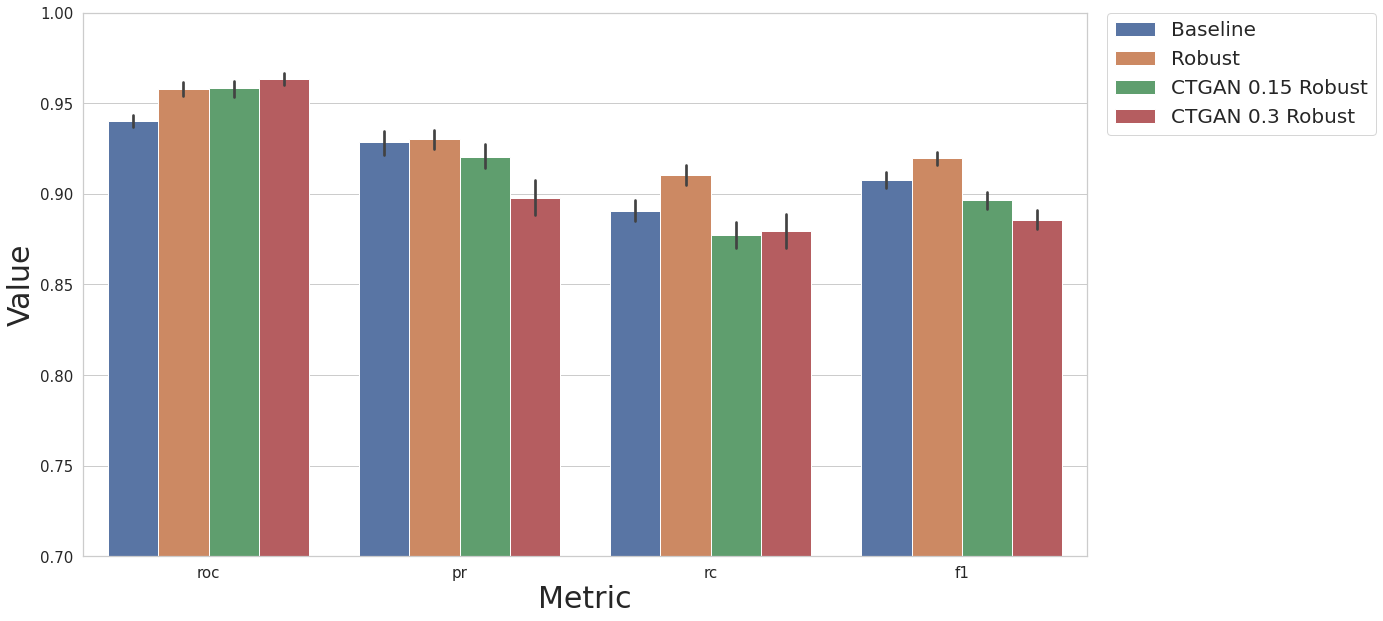

In [16]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

### XGBoost

After the extensive experimenting with KNN models, we can also perform the same comparisons of experiments with XGBoost models instead. The following cells demonstrate this.

In [17]:
MODEL_NAME = "xgb"

result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

result_cor = test_corr(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(result_df, result_cor, "Corr.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataStandardScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Std.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataMinMaxScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Min/Max.")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataQuantileTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Quantile")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataNormalizer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Normalizer")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataRobustScaler, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Robust")

result_tr = test_corr_transf(df, label_col, N_EXEC, dp.DataPowerTransformer, MODEL_NAME, num_col)
result_df = cs.add_results_df(result_df, result_tr, "Power")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

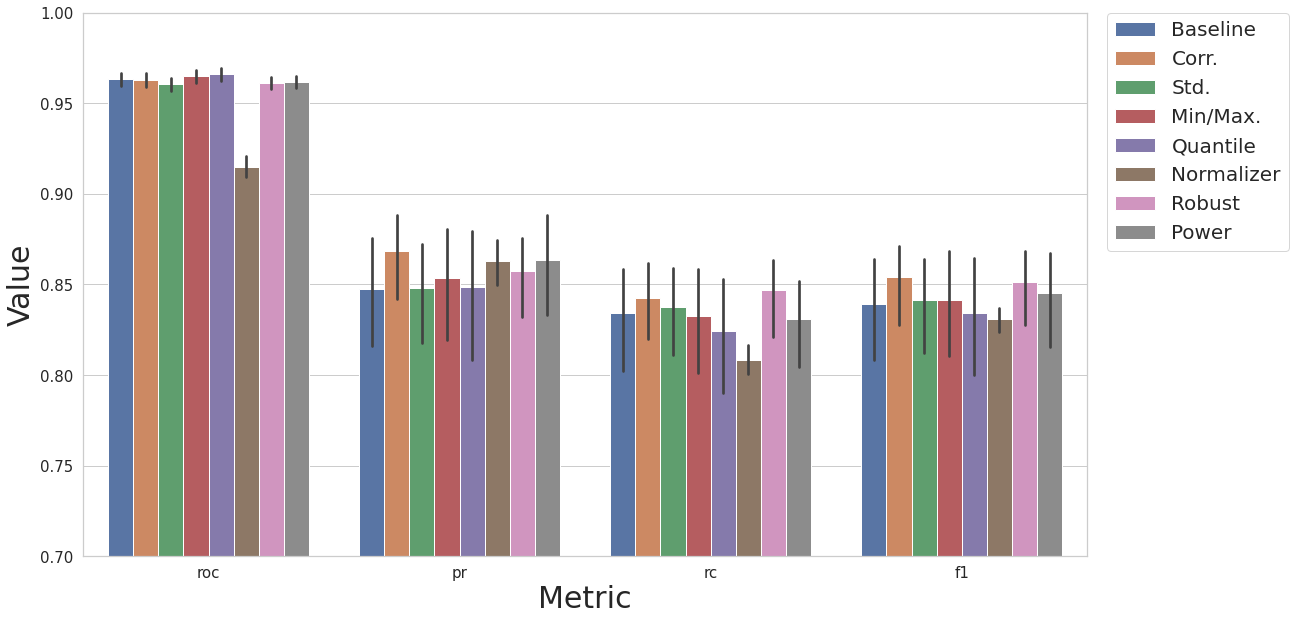

In [18]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

In [19]:
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type='backward')
result_df = cs.add_results_df(result_df, restult_fs, "Seq.Bwd.Qtl.")

restult_fs = test_smote_transf(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type='catboost')
result_df = cs.add_results_df(result_df, restult_fs, "CatBoost Qtl.")

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigat

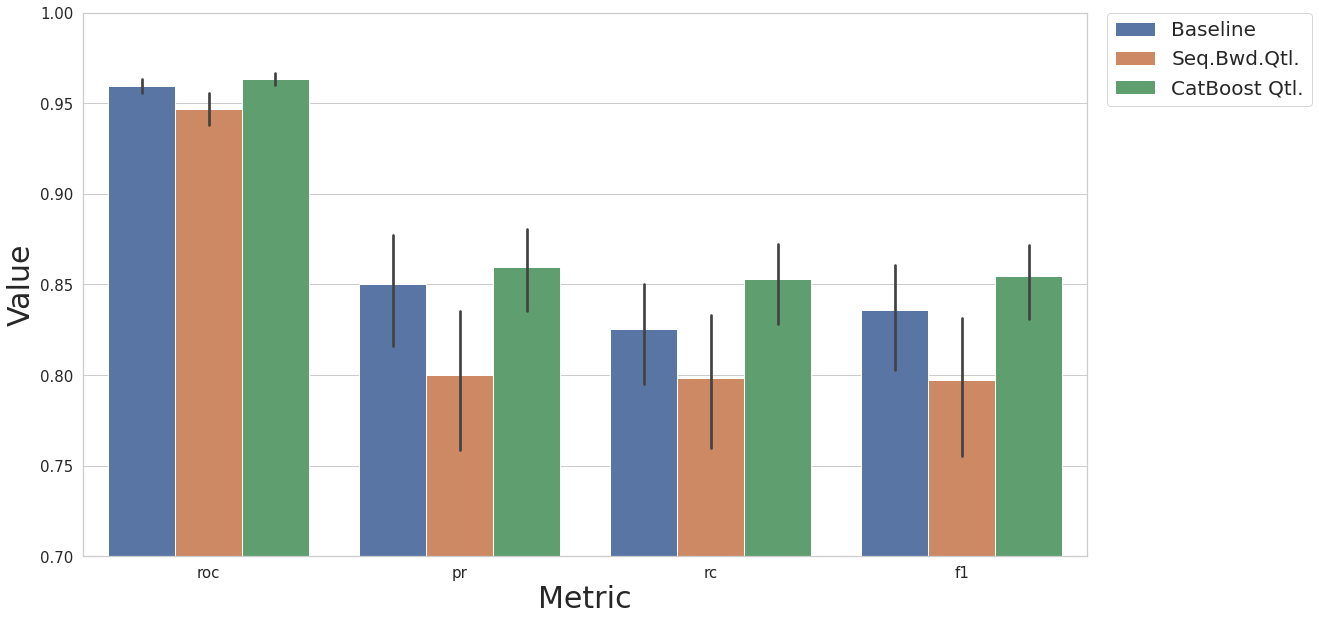

In [20]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])

In [21]:
MODEL_NAME = "xgb"
result_base = test_base(df, label_col, N_EXEC, MODEL_NAME)
result_df = cs.add_results_df(None, result_base, "Baseline")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.1, savefile="2_3.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.1")

restult_fs = test_ctgan_first(df, label_col, N_EXEC, MODEL_NAME, rcorr=True, scaler_ref=None, feat_sel_type=None, art_str=0.15, savefile="2_4.pkl")
result_df = cs.add_results_df(result_df, restult_fs, "CTGAN 0.15")


/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/dataprocessing/model_utils.py:97: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


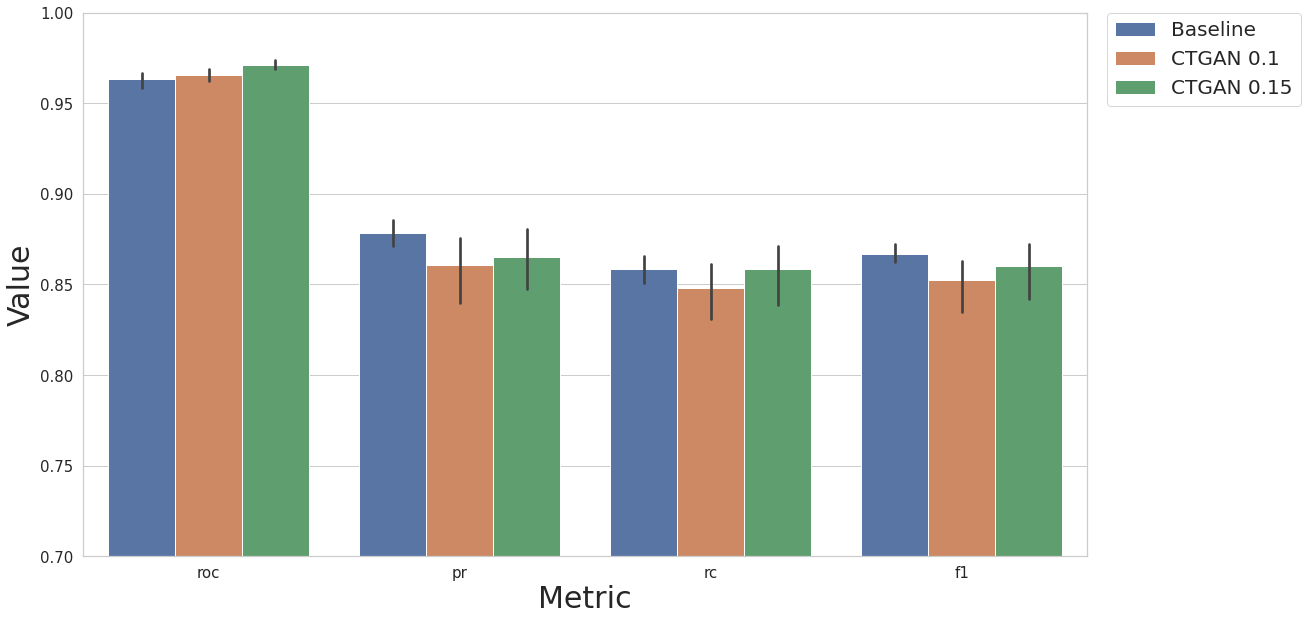

In [22]:
cs.plot_results(result_df, y_lim=[0.7, 1.0])